In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

sys.path.append("..")

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = .001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    params[6] = 13 + 125*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

def getStablePoint(params, consts):
    #I stable point = (b0/gamm0 - 1)^(1/b2) / b1
    #A stable point = nu/gamma1 * (b0/gamm0 - 1)^(1/b2) / b1
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    beta = params[5:]
    
    return (beta[0]/gamma0 - 1)**(1/beta[2]) / beta[1]

10
Italy [0.007701757277441129, 0.00035206391425336904, 0.32414596532803197, 0.32015237917397077, 0.024135340525104913, 0.36397505470220093, 52.31410513728453, 1.9228765430482753] 2020-02-26 2021-08-19
United States [0.004476151061741285, 0.0031009631558855475, 6.759694588752645, 0.0100700112176004, 0.008013140806800607, 6.891283711344126, 66.17623249299851, 8.472783906645372] 2020-03-05 2021-08-19
United Kingdom [0.022944531651996364, 3.0339818530283072e-06, 0.4838791312888092, 0.24376733375928966, 0.03941720928539221, 0.5404192824538588, 14.542624602768747, 0.8170031325362014] 2020-04-01 2021-08-19
Canada [0.003306450878020551, 3.0714541318802256e-14, 0.942258155711383, 0.00011153900651622094, 0.009460117035856391, 1.2959930820044772, 66.08590523721728, 1.0961771987598374] 2020-02-25 2021-08-19
Mexico [0.0016030663437700625, 0.0033335372151232306, 0.19274762155582953, 0.00651707172060619, 0.003133836584732981, 0.3645087987286656, 140.5030238777783, 0.9681399863452846] 2020-03-28 2021

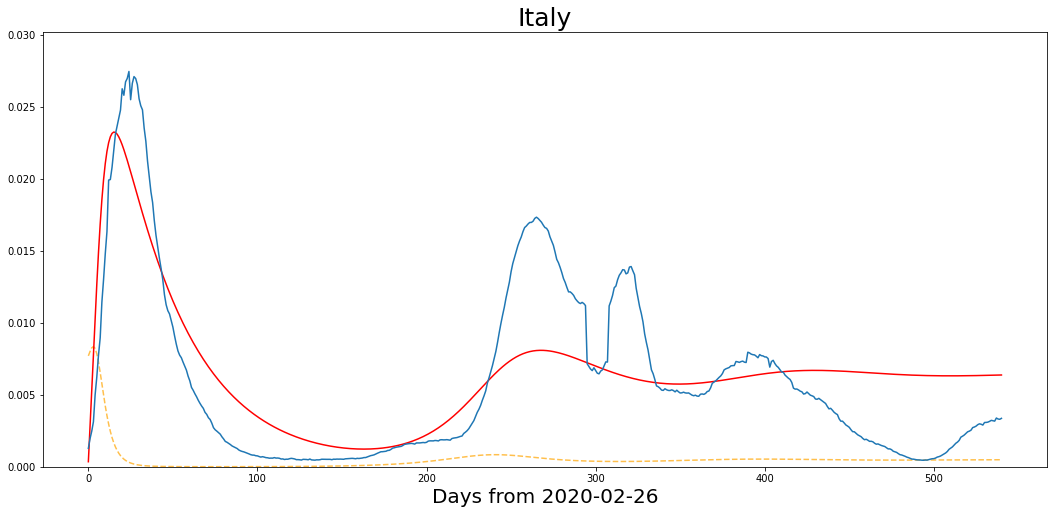

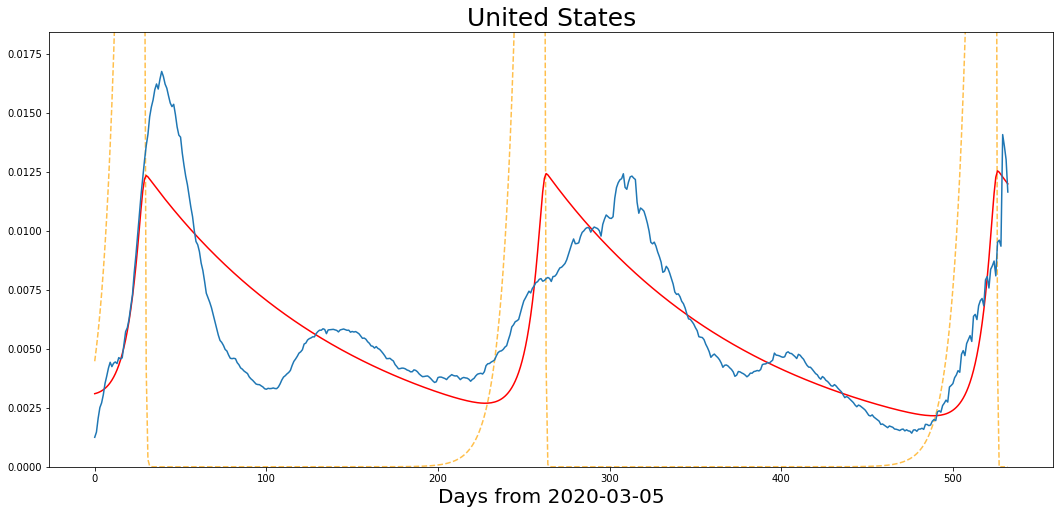

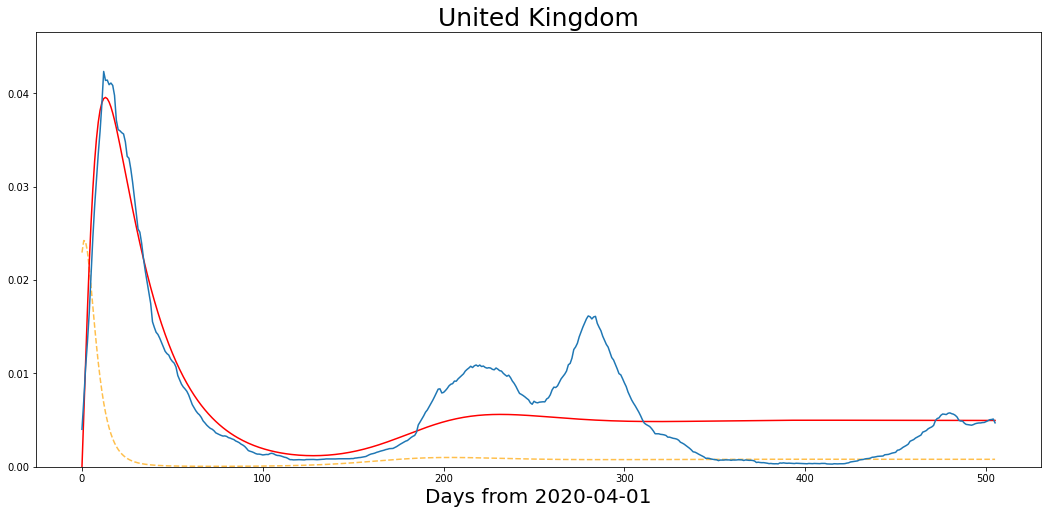

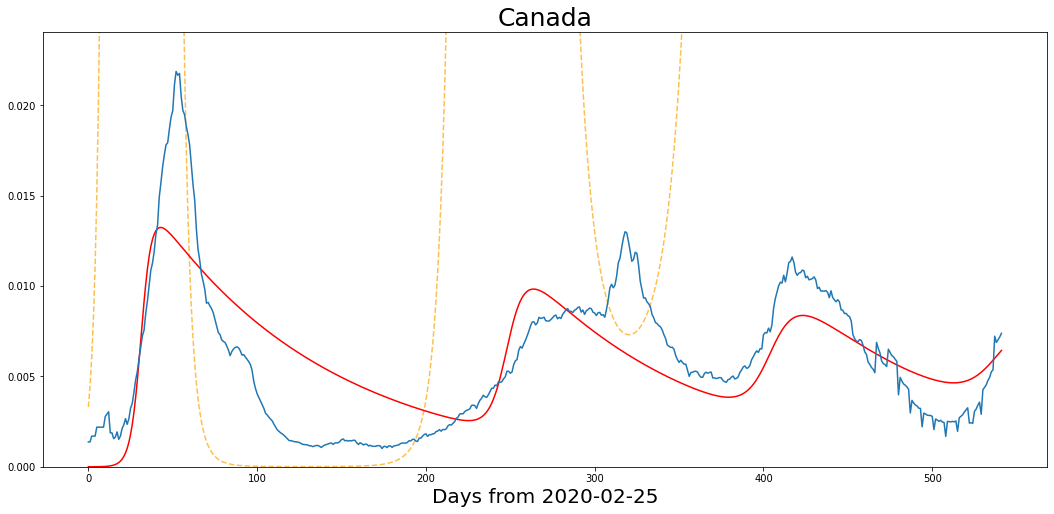

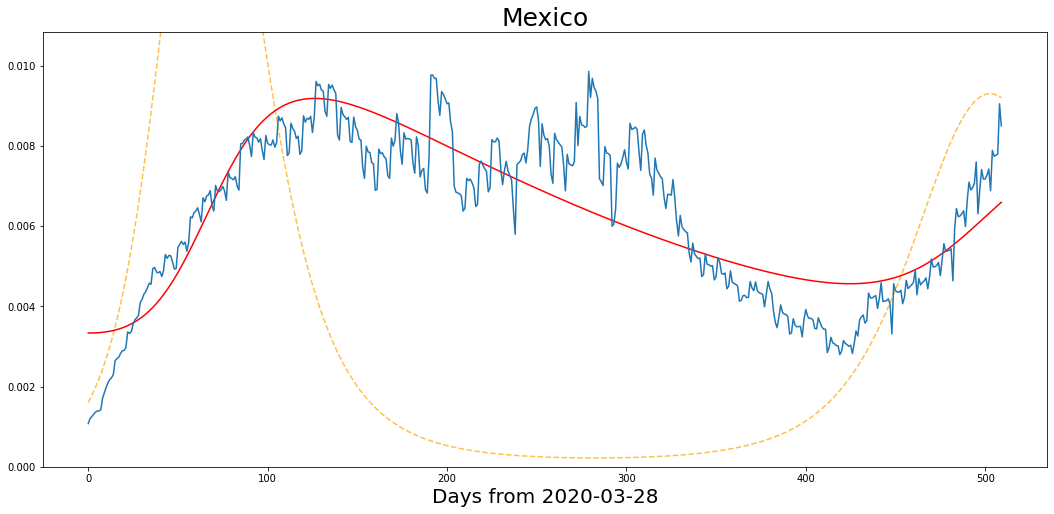

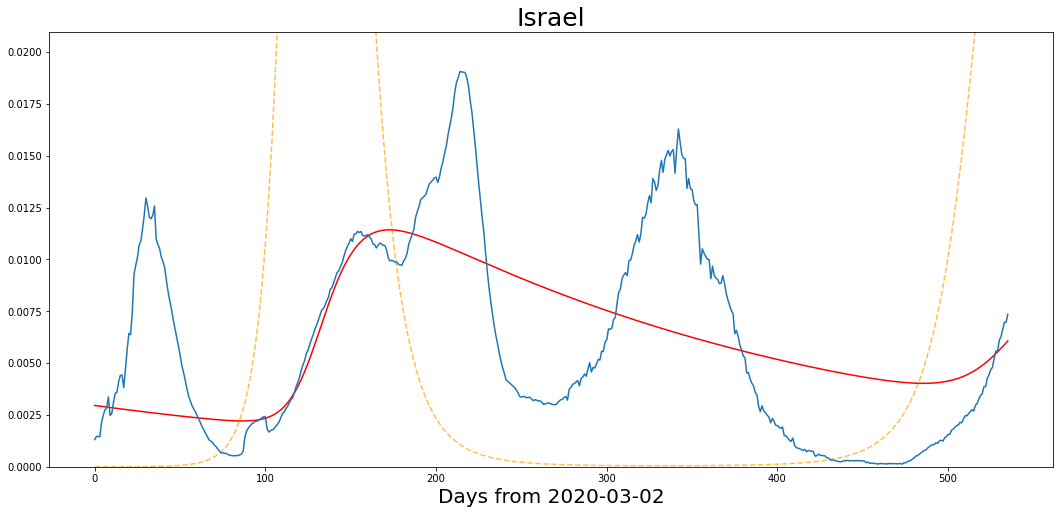

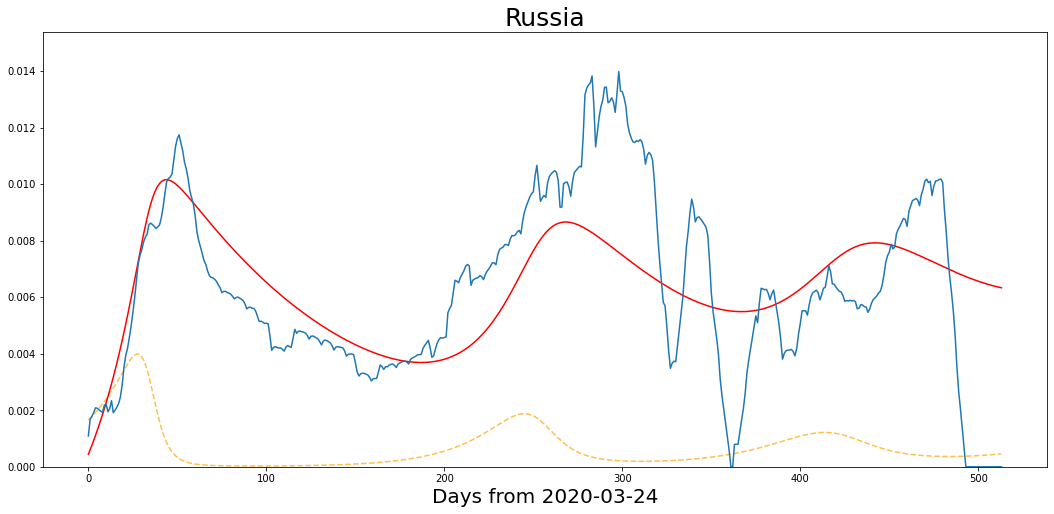

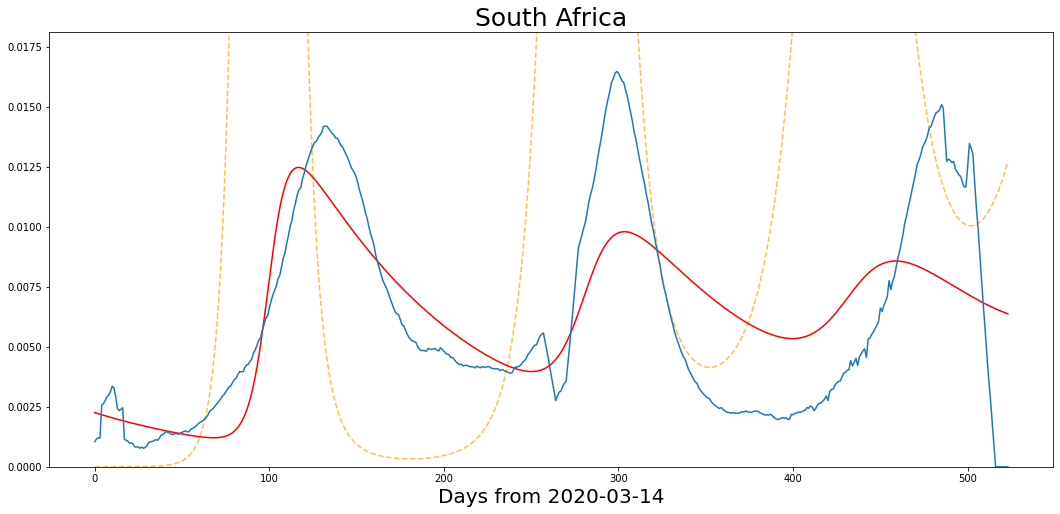

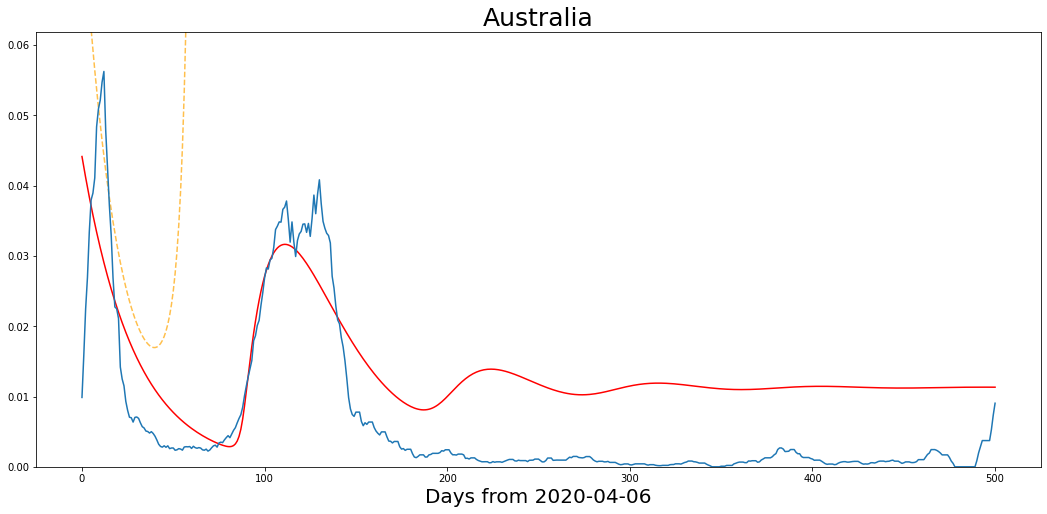

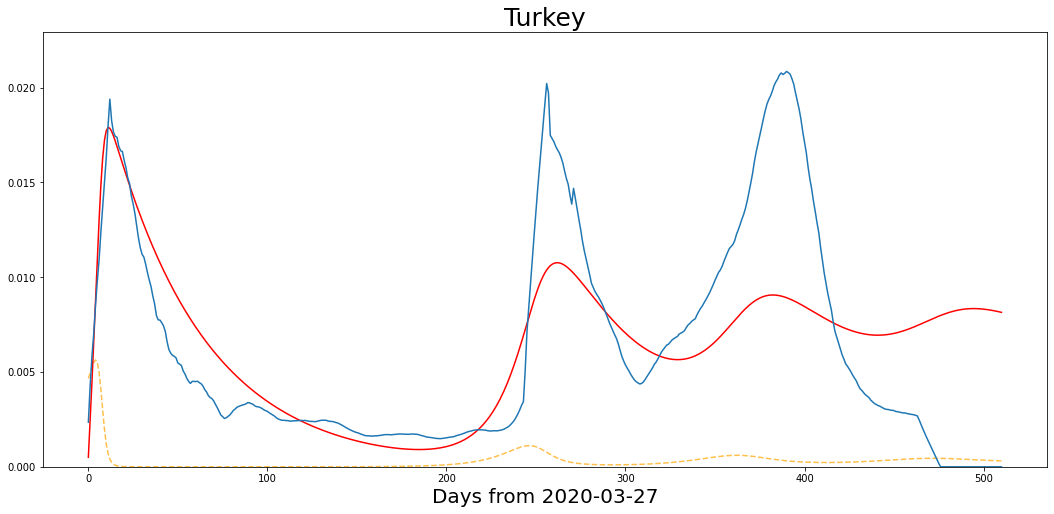

In [7]:
import csv
import platform
fileName = "../../Data/AIRD fits/fits2.csv" #mac file address
#pathc="../Data/Covid Tracking State Data/"
if platform.system() == "Windows":
    fileName.replace("/", "\\")

csvFile = open(fileName, newline='', encoding='UTF-8')
rd = csv.reader(csvFile, delimiter=',') #reader
data=[] #the data of all countries
for lv in rd: #generating the data matrix
    data.append(lv)

#data = np.array(data) #convert to np array for simplicity

print(len(data))

for i in range(len(data)):
    country = data[i][0]
    params =  list(map(float,data[i][1:]))
    
    dates, I, R, D, V = owid.LoadCountryNormal(country)
    consts = [len(I), I[0], max(I), 0]
    
    print(country, params, dates[0], dates[-1])
    
    fig, ax = graphParams(params, consts, graphA=True)
    ax.set_title(country, fontsize=25)
    ax.set_xlabel("Days from " + dates[0], fontsize=20)
    ax.plot(I)
    ax.set_ylim([0, max(I)*1.1])
    
    measureDates = getCountryDates(country)

    for measure in measureDates:
        if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

## Italy

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.983976070268913e-05
3 New best error:  1.629003891877367e-05
4 New best error:  1.6285392900776117e-05
53 New best error:  1.5089456433966014e-05
70 New best error:  1.3800943956034706e-05
[7.70175728e-03 3.52063914e-04 3.24145965e-01 3.20152379e-01
 2.41353405e-02 3.63975055e-01 5.23141051e+01 1.92287654e+00]


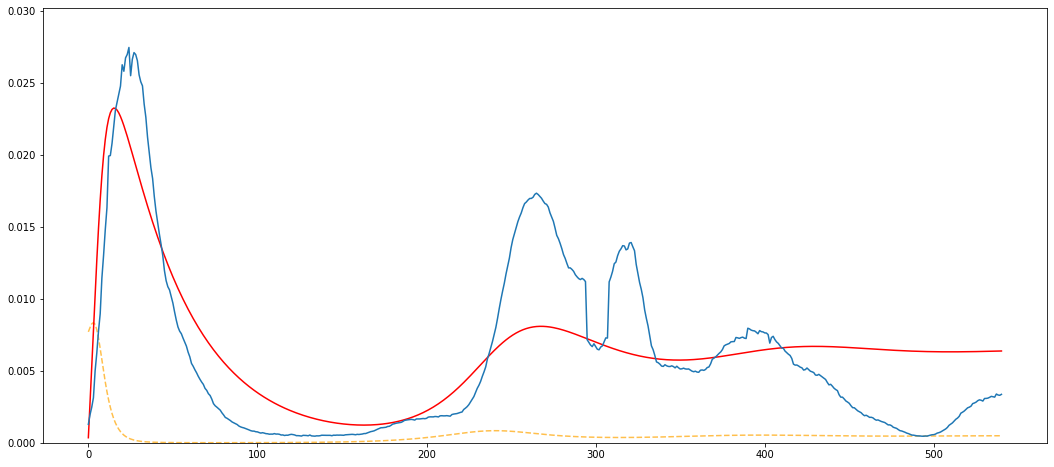

In [85]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

italyParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")


fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(italyParams)

## US

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  6.925499138191984e-06
1 New best error:  6.080639338274261e-06
3 New best error:  5.845471844548533e-06
24 New best error:  5.8410799866436806e-06
26 New best error:  5.805113919612488e-06
38 New best error:  3.4667789683608538e-06


(0.0, 0.018441267693175955)

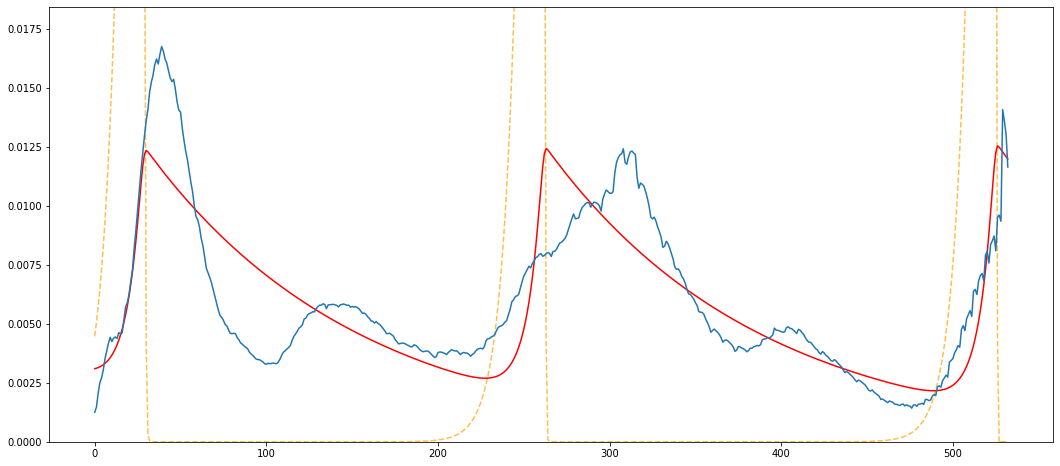

In [86]:
dates, I, R, D, V = owid.LoadCountryNormal("United States")
consts = [len(I), I[0], max(I), 0]

usParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(usParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## UK

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.9580925045047105e-05
7 New best error:  1.6745204860020698e-05
9 New best error:  1.4773657513329569e-05
21 New best error:  1.3511781407435582e-05
28 New best error:  1.330494993395692e-05


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


41 New best error:  1.218220177118754e-05


(0.0, 0.04658249629830908)

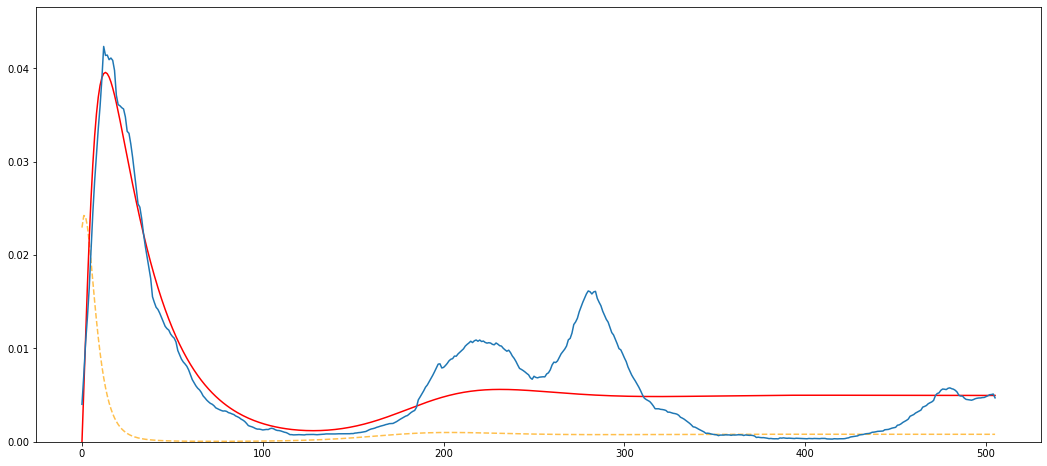

In [87]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Canada

0 New best error:  9.197837284979115e-06


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  7.589209407183045e-06
9 New best error:  7.545428992303023e-06
32 New best error:  7.415713621602136e-06
73 New best error:  7.410097985464217e-06


(0.0, 0.02405621083757516)

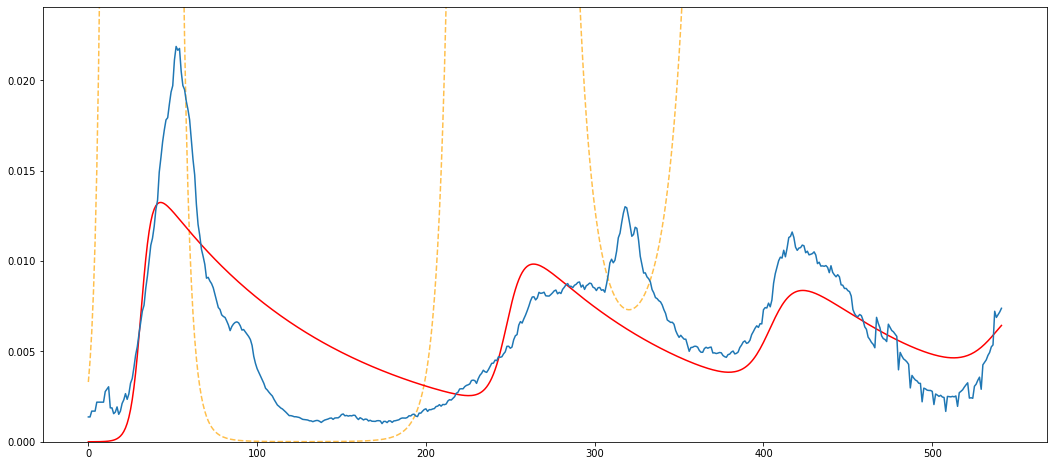

In [88]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada")
consts = [len(I), I[0], max(I), 0]

canadaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(canadaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Mexico

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.2566367399330728e-06
1 New best error:  1.226555620168404e-06
2 New best error:  1.1308111368373588e-06
8 New best error:  1.1091323265151932e-06


(0.0, 0.010837001598060553)

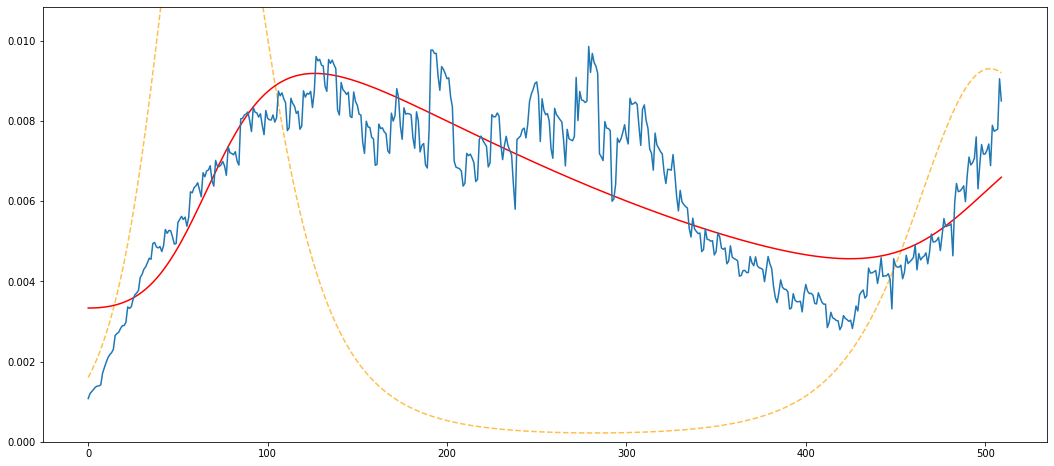

In [89]:
dates, I, R, D, V = owid.LoadCountryNormal("Mexico")
consts = [len(I), I[0], max(I), 0]

mexicoParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(mexicoParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Israel

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.1839711881965447e-05
6 New best error:  2.1507365457204815e-05
9 New best error:  1.954570718878043e-05
10 New best error:  1.951810706236965e-05
16 New best error:  1.6695130483104395e-05
30 New best error:  1.5557631169054945e-05


(0.0, 0.020971920205352997)

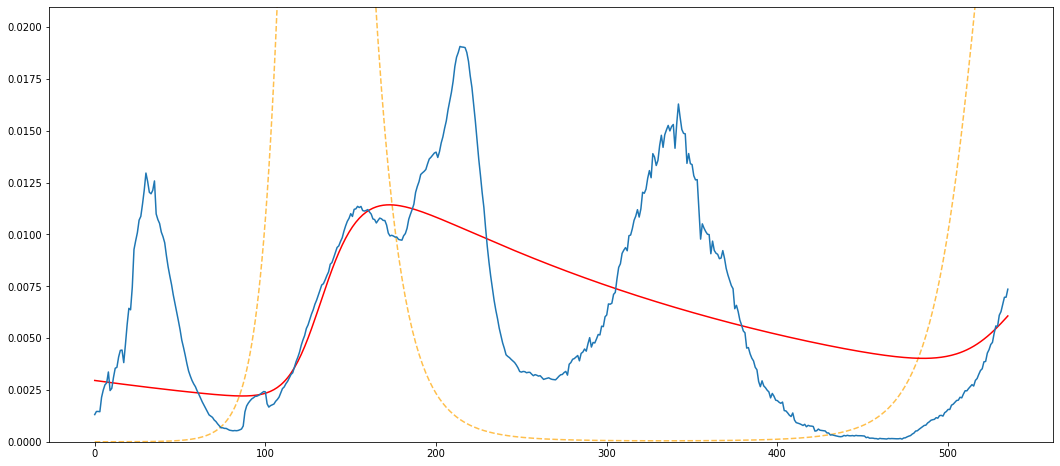

In [90]:
dates, I, R, D, V = owid.LoadCountryNormal("Israel")
consts = [len(I), I[0], max(I), 0]

israelParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(israelParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Russia

0 New best error:  6.6543448053483175e-06
3 New best error:  6.53954592015547e-06


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


8 New best error:  6.464942080236156e-06
12 New best error:  6.271664528754671e-06


(0.0, 0.015384002666381675)

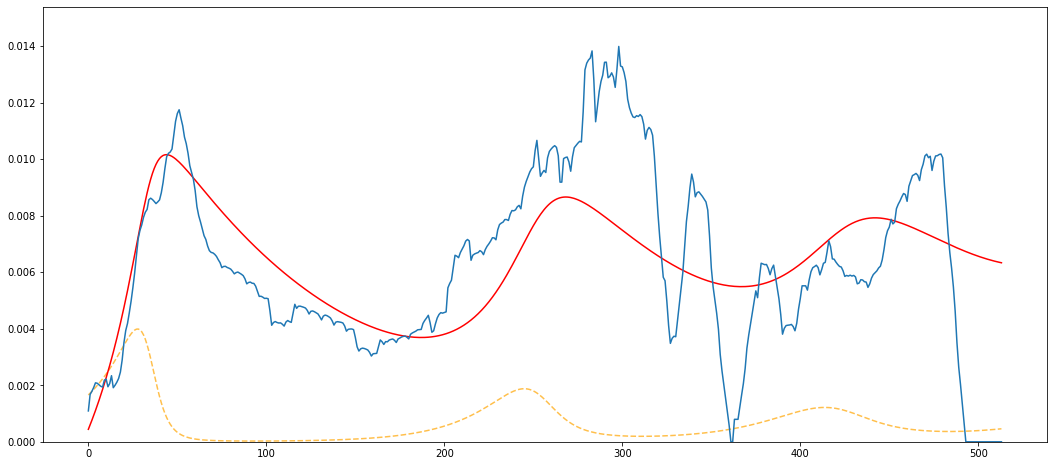

In [91]:
dates, I, R, D, V = owid.LoadCountryNormal("Russia")
consts = [len(I), I[0], max(I), 0]

russiaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(russiaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## South Africa

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  9.225838623636818e-06
2 New best error:  8.815055249946102e-06
10 New best error:  8.627546231446031e-06
76 New best error:  8.558139123395923e-06


(0.0, 0.01813797736939064)

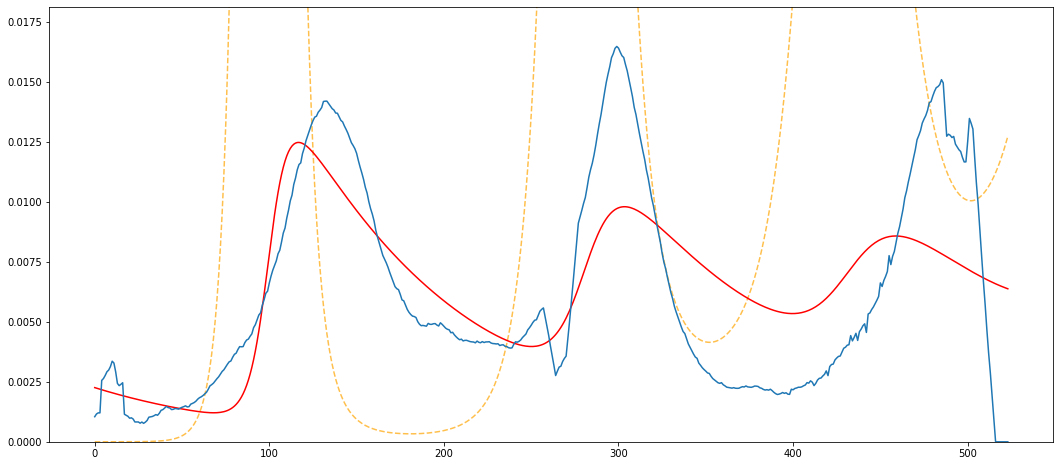

In [92]:
dates, I, R, D, V = owid.LoadCountryNormal("South Africa")
consts = [len(I), I[0], max(I), 0]

southAfricaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(southAfricaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Australia

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  8.726565681000965e-05
3 New best error:  6.788424893408381e-05
34 New best error:  6.181344901927018e-05


<ipython-input-84-6a3f38c511c6>:147: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


(0.0, 0.06187422274640893)

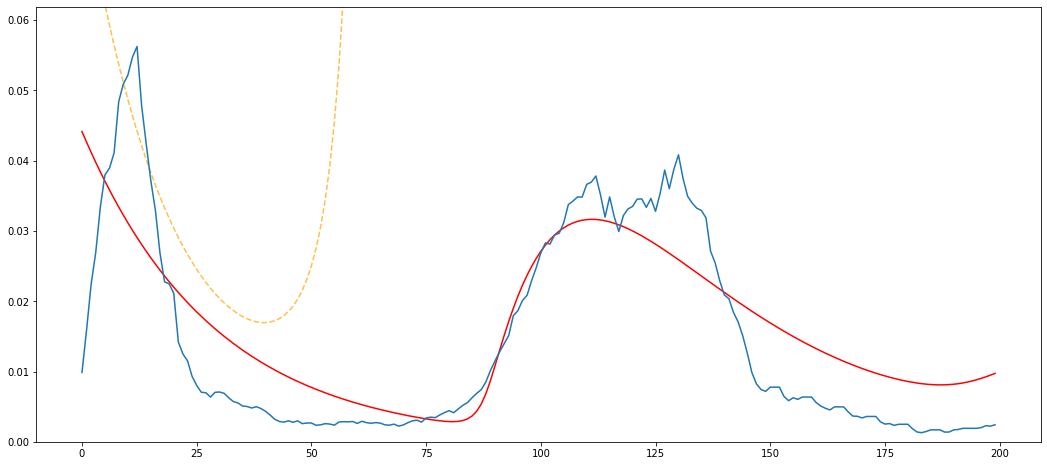

In [93]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")
dates = dates[0:200]
I = I[0:200]
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Turkey

0 New best error:  2.7015933102820893e-05


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  1.9043030250452358e-05
2 New best error:  1.739042980460253e-05
18 New best error:  1.681666666396388e-05


(0.0, 0.0291976837360973)

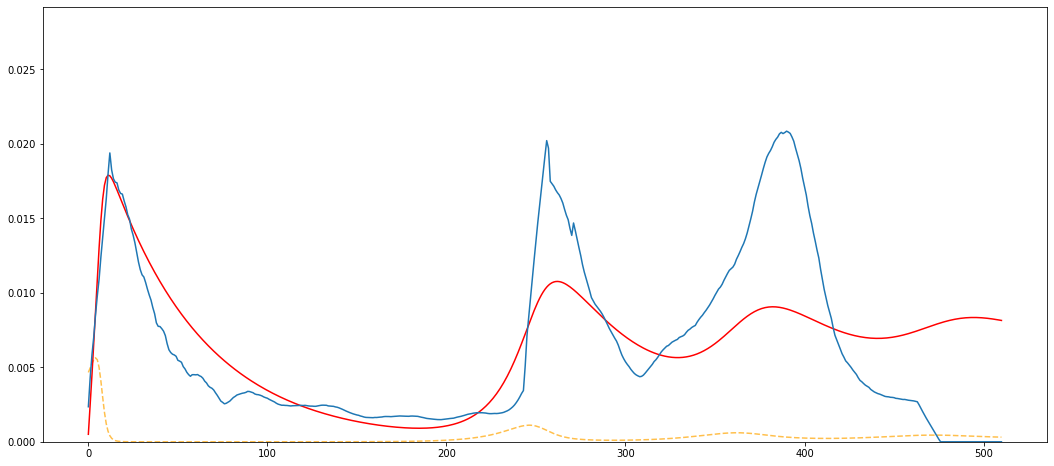

In [94]:
dates, I, R, D, V = owid.LoadCountryNormal("Turkey")

consts = [len(I), I[0], max(I), 0]

turkeyParams = getParams(I, consts, randomIterCount=100, wDecay=(.75**(1/len(I))), method = "Nelder-Mead")

fig,ax = graphParams(turkeyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.4])

In [95]:
import csv


outputFile = open('..\\Data\\AIRD fits\\fits2.csv', 'w')
writer = csv.writer(outputFile)


row = italyParams.tolist()
row.insert(0, "Italy")
writer.writerow(row)

row = usParams.tolist()
row.insert(0, "United States")
writer.writerow(row)

row = ukParams.tolist()
row.insert(0, "United Kingdom")
writer.writerow(row)

row = canadaParams.tolist()
row.insert(0, "Canada")
writer.writerow(row)

row = mexicoParams.tolist()
row.insert(0, "Mexico")
writer.writerow(row)

row = israelParams.tolist()
row.insert(0, "Israel")
writer.writerow(row)

row = russiaParams.tolist()
row.insert(0, "Russia")
writer.writerow(row)

row = southAfricaParams.tolist()
row.insert(0, "South Africa")
writer.writerow(row)

row = auParams.tolist()
row.insert(0, "Australia")
writer.writerow(row)

row = turkeyParams.tolist()
row.insert(0, "Turkey")
writer.writerow(row)

outputFile.close()

2020-03-01
2020-11-06


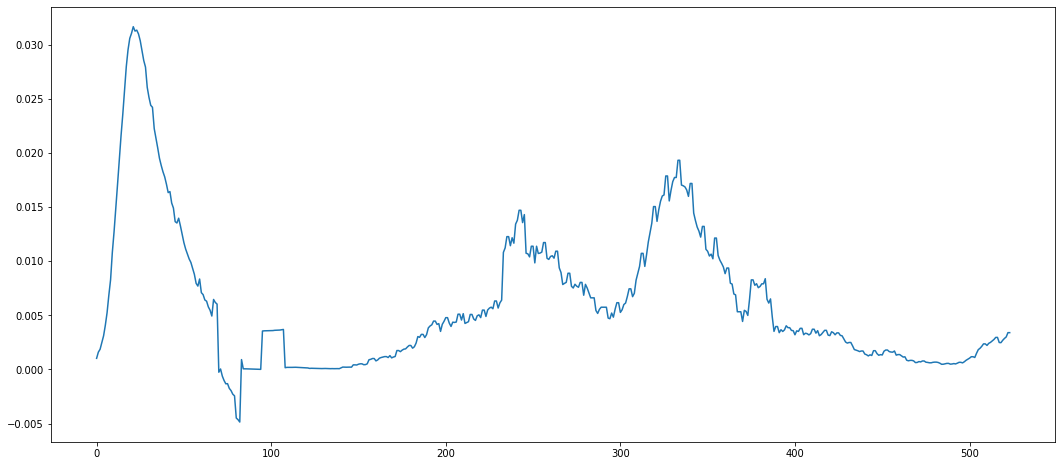

In [14]:
countryName = "Spain"

dates, I, R, D, V = owid.LoadCountryNormalDeaths(countryName)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(I)
print(dates[0])
print(dates[250])

normal-death error:  nan
mod-death error:  nan
mod/normal error: nan


C:\Users\daniel\OneDrive\Documents\GitHub\COVID-Tracking-Biola-Summer\Code\Models\OWID.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  I = I * (.25/(max(I))) #adjust so it matches max = .1, this is arbitrary
C:\Users\daniel\OneDrive\Documents\GitHub\COVID-Tracking-Biola-Summer\Code\Models\OWID.py:63: RuntimeWarning: invalid value encountered in multiply
  I = I * (.25/(max(I))) #adjust so it matches max = .1, this is arbitrary


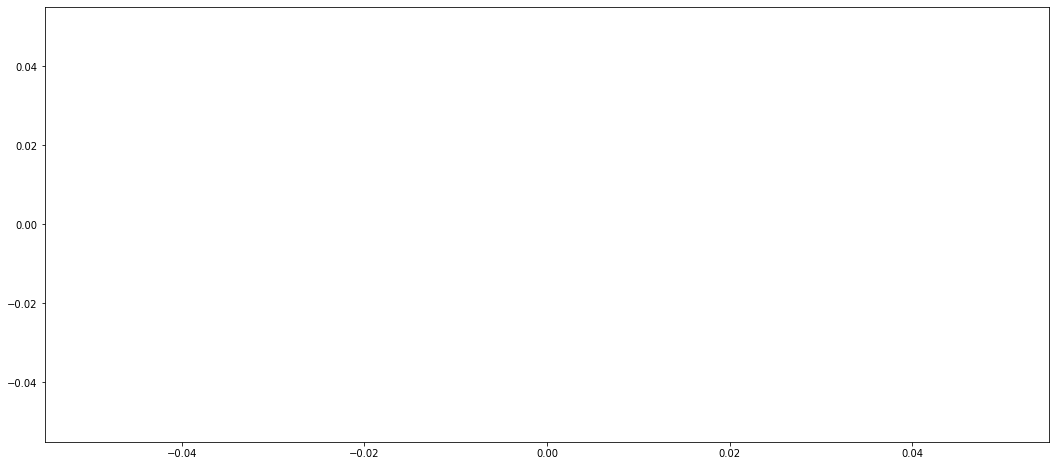

In [6]:
countryName = "Spain"

dates, I, R, D, V = owid.LoadCountryNormal(countryName)

dates2, [actualI, pop] = owid.LoadCountry(countryName, [4, 46])

startDate = np.where(dates2 == dates[0])[0][0]
endDate = np.where(dates2 == dates[-1])[0][0]

dates2 = dates2[startDate:endDate+1]
actualI = actualI[startDate:endDate+1]
pop = pop[0]

actualI = actualI/pop #transform so max pop is 1

shiftAmount = 15
deadShift = D[shiftAmount:]
modIShift = I[0:-shiftAmount] + R[0:-shiftAmount]
actualIShift = actualI[0:-shiftAmount]

fig,ax = plt.subplots(figsize=(18,8))

deathScale = (sum(modIShift)/len(modIShift)) / (sum(deadShift)/len(deadShift))
infectScale = (sum(modIShift)/len(modIShift)) / (sum(actualIShift)/len(actualIShift))

ax.plot(modIShift, color="red")
ax.plot(infectScale*actualIShift, color="blue")
ax.plot(deathScale*deadShift, color="black")

normalError = sum(((infectScale*actualIShift)-(deathScale*deadShift))**2)
modError = sum(((modIShift)-(deathScale*deadShift))**2)
print("normal-death error: ", normalError)
print("mod-death error: ", modError)
print("mod/normal error:", modError/normalError)

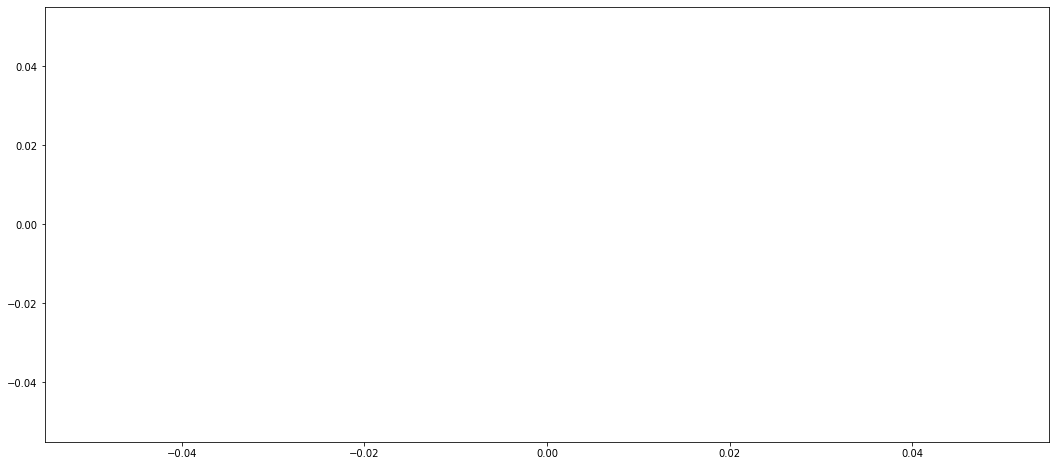

In [7]:
fig, ax = plt.subplots(figsize=(18,8))

recov = np.zeros(len(deadShift)) #R+D
shift = 14
for i in range(len(deadShift) - shift):
        recov[i + shift] = deadShift[i]

reportedI = actualIShift
recov2 = np.zeros(len(deadShift)) #R+D
for i in range(len(reportedI) - shift):
        recov2[i + shift] = reportedI[i]

reportedI = reportedI - recov2
currInfect = deadShift - recov
modIShift = I[0:-shiftAmount]

currInfect = currInfect * (sum(modIShift)/len(modIShift)) / (sum(currInfect)/len(currInfect))
reportedI = reportedI * (sum(modIShift)/len(modIShift)) / (sum(reportedI)/len(reportedI))

ax.plot(currInfect, color="black") #approx from dead
ax.plot(modIShift, color="orange") #approx from tests
ax.plot(reportedI, color="green") #reported

<ipython-input-83-1d4c2a5be5ad>:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(newCases/newTests, color="red") #percent of positive tests
<ipython-input-83-1d4c2a5be5ad>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(newCases/newTests, color="red") #percent of positive tests


(0.0, 1.05)

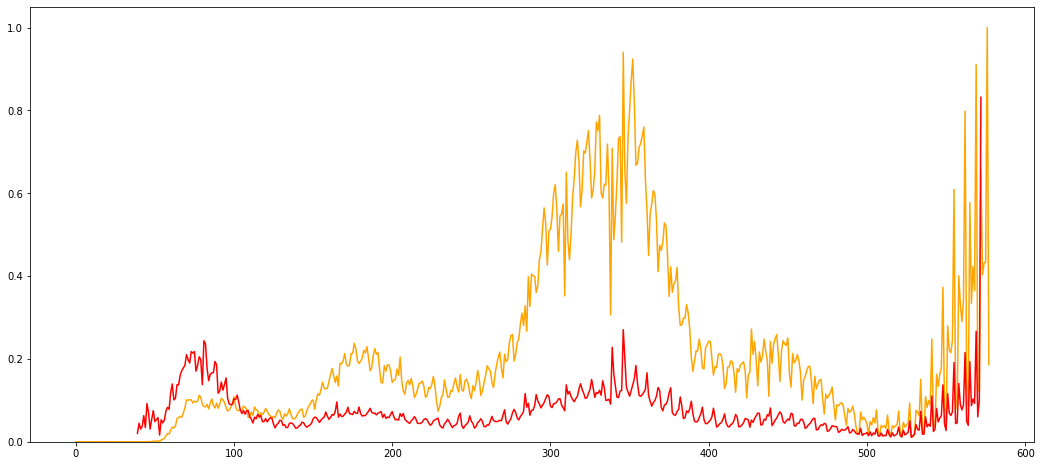

In [83]:
dates3, [newCases, newTests] = owid.LoadCountry("United States", [5, 25])

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(newCases/max(newCases), color="orange") #scaling is arbitrary
ax.plot(newCases/newTests, color="red") #percent of positive tests
ax.set_ylim(0)

In [6]:
def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found

import csv
import platform
import os.path
def getCountryDates(countryName):
    fileName = "../Data/Country Policy Data/" #mac file address
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")
    fileName = fileName+countryName + ".csv"
    
    if(not os.path.exists(fileName)):
        return []
    
    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity
    
    return data[:,0].transpose() #just the dates

## Regions of constant period (for Italy, United Kingdom, Australia)

# Italy

[0.007701757277441129, 0.00035206391425336904, 0.32414596532803197, 0.32015237917397077, 0.024135340525104913, 0.36397505470220093, 52.31410513728453, 1.9228765430482753]


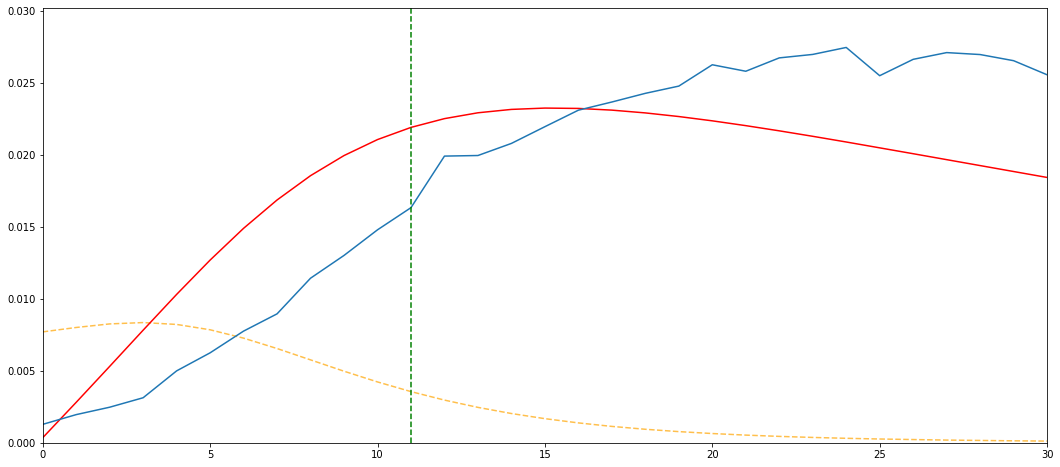

In [19]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

#italyParams = getParams(I, consts, randomIterCount=10, method = "Nelder-Mead")
italyParams = [0.007701757277441129,0.00035206391425336904,0.32414596532803197,0.32015237917397077,0.024135340525104913,
               0.36397505470220093,52.31410513728453,1.9228765430482753]

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

ax.set_xlim([0, 30])

print(italyParams)

measureDates = getCountryDates("Italy")

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

Italy [2.23365818e-02 1.32053527e-02 2.79784418e-01 1.66558179e-01
 3.65974564e-02 3.08512429e-01 5.23412347e+01 1.75658754e+00] 2020-03-08 2020-11-04


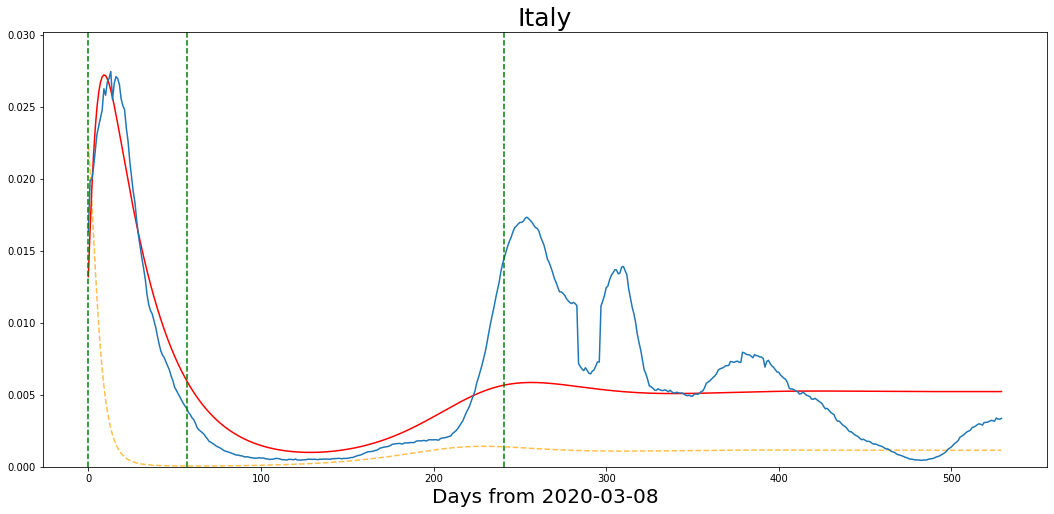

In [5]:
measureDates = getCountryDates("Italy")
    
dates, I, R, D, V = owid.LoadCountryNormal("Italy")

startDate = getIndex(dates, measureDates[0])
endDate = getIndex(dates, measureDates[2])

dates2 = dates[startDate:]
I2 = I[startDate:]

dates = dates[startDate:endDate+1]
I = I[startDate:endDate+1]

consts = [len(I), I[0], max(I), 0]

consts2 = [len(I2), I2[0], max(I2), 0]

#italyParamsLate = getParams(I, consts, randomIterCount=5, method = "Nelder-Mead")

fig,ax = graphParams(italyParamsLate, consts2, graphA=True)
ax.plot(I2)
ax.set_ylim([0, max(I)*1.1])

ax.set_title("Italy", fontsize=25)
ax.set_xlabel("Days from " + dates[0], fontsize=20)

measureDates = getCountryDates("Italy")

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')
        
            
print("Italy", italyParamsLate, dates[0], dates[-1])

# United Kingdom

0 New best error:  2.0276408683047067e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


4 New best error:  1.566424940834041e-05
7 New best error:  1.4322251913889555e-05


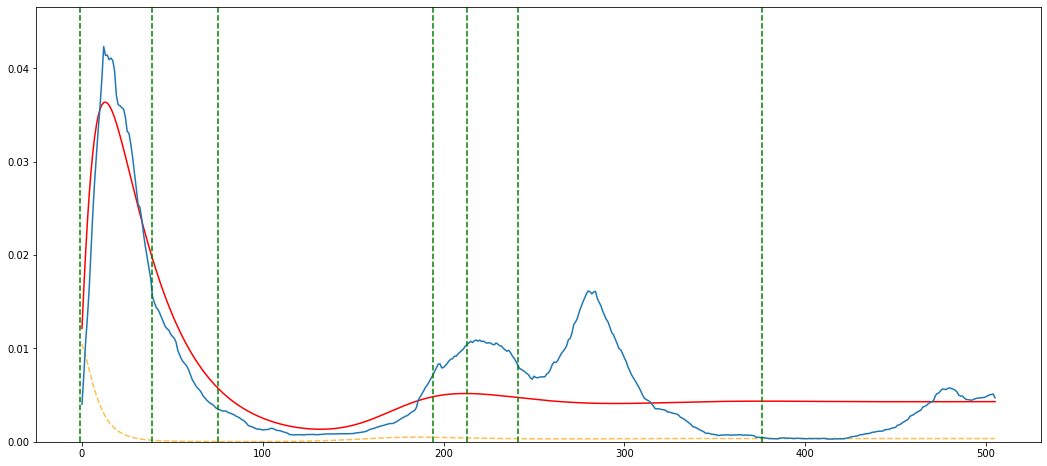

In [22]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=15, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

measureDates = getCountryDates("United Kingdom")

for measure in measureDates:
    plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

0 New best error:  6.7158445619165704e-06
1 New best error:  6.559542570429962e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


4 New best error:  6.539119237790088e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in double_scalars


United Kingdom [1.06623150e-02 7.67486228e-03 2.37022582e-01 4.96581302e-02
 1.39806657e-02 4.91306521e-01 3.18267848e+02 4.36853865e-01] 2020-10-31 2021-08-19


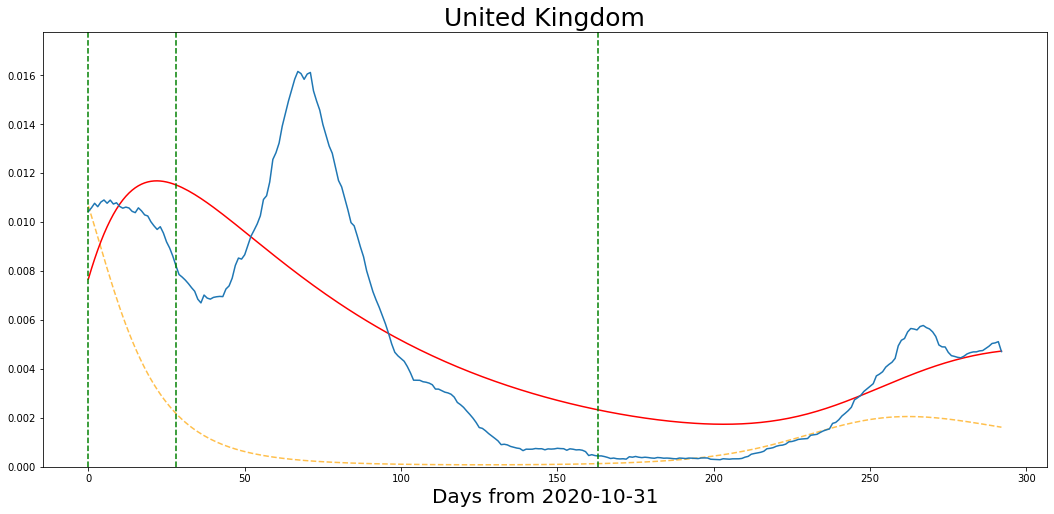

In [41]:
measureDates = getCountryDates("United Kingdom")
    
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")

startDate = getIndex(dates, measureDates[-3])

dates = dates[startDate:]
I = I[startDate:]

consts = [len(I), I[0], max(I), 0]

ukParamsLate = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(ukParamsLate, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

ax.set_title("United Kingdom", fontsize=25)
ax.set_xlabel("Days from " + dates[0], fontsize=20)

measureDates = getCountryDates("United Kingdom")

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')
            
print("United Kingdom", ukParamsLate, dates[0], dates[-1])

# Australia

[1.08328970e-05 2.03680779e-02 8.89803072e-02 3.77751393e-10
 3.67327150e-02 3.50363788e+00 9.85064700e+02 4.88942870e+00]


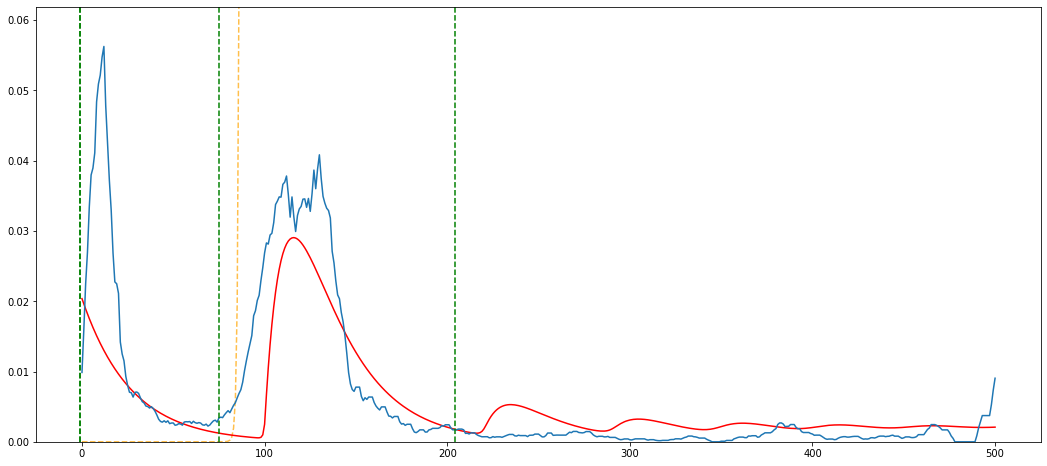

In [21]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=10, method = "Nelder-Mead")


fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(auParams)

measureDates = getCountryDates("Australia")

for measure in measureDates:
    plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  5.3872535307233174e-05
1 New best error:  1.9325766575740065e-05
2 New best error:  1.9265446109915213e-05
12 New best error:  1.9045890432142057e-05
21 New best error:  1.889976084861248e-05
Australia [1.04646189e-02 7.39476319e-23 2.20436402e-01 1.91553772e-01
 3.08201462e-02 3.81567467e-01 8.51083841e+01 1.26532426e-01] 2020-06-20 2021-08-19


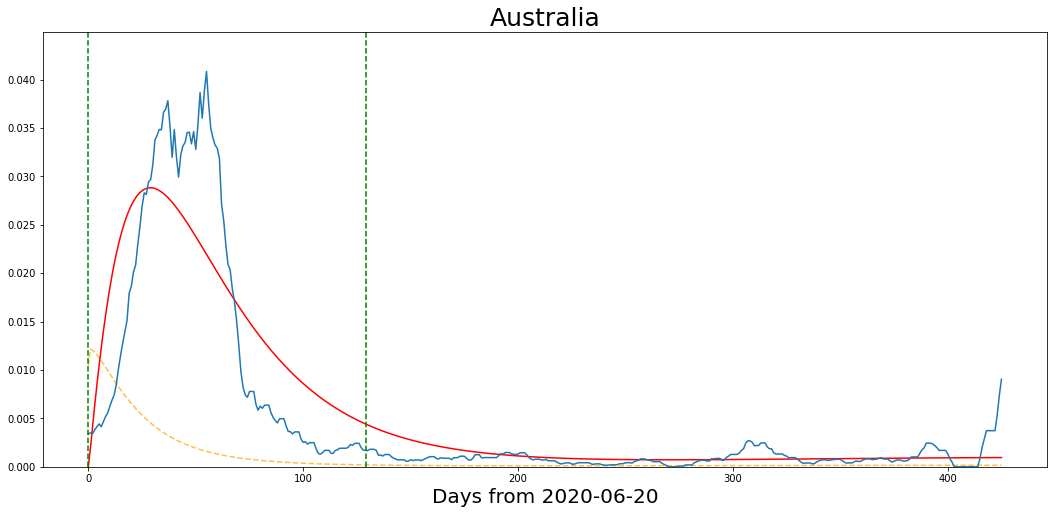

In [43]:
measureDates = getCountryDates("Australia")
    
dates, I, R, D, V = owid.LoadCountryNormal("Australia")

startDate = getIndex(dates, measureDates[-2])

dates = dates[startDate:]
I = I[startDate:]

consts = [len(I), I[0], max(I), 0]

auParamsLate = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(auParamsLate, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])


ax.set_title("Australia", fontsize=25)
ax.set_xlabel("Days from " + dates[0], fontsize=20)

measureDates = getCountryDates("Australia")

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')
            
print("Australia", auParamsLate, dates[0], dates[-1])

## Canada

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  9.050627090400618e-06
3 New best error:  7.743717794408354e-06
4 New best error:  7.7107728889726e-06
8 New best error:  7.452994251601756e-06
[1.10132450e-03 1.23009240e-04 1.05664806e+00 1.67817421e-02
 9.06415759e-03 1.17753861e+00 9.06131970e+01 8.15196871e+00]


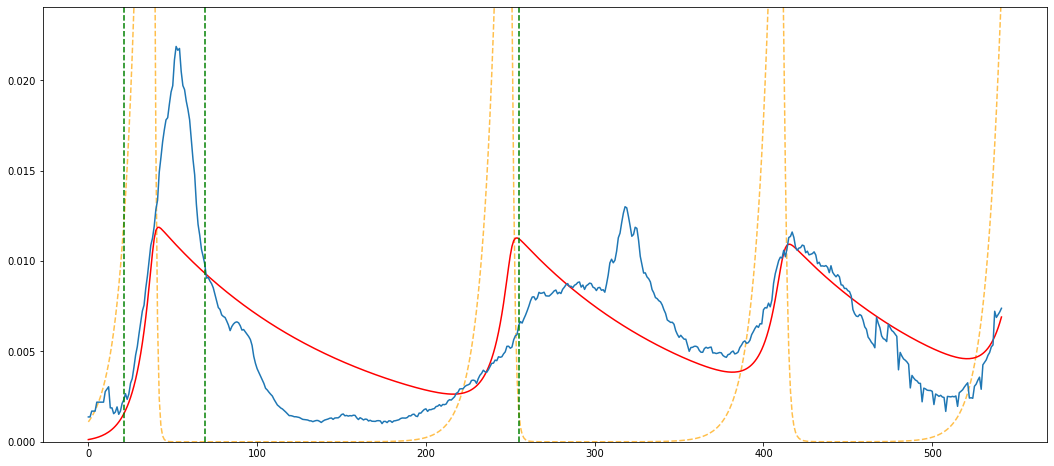

In [11]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada")
consts = [len(I), I[0], max(I), 0]

canadaParams = getParams(I, consts, randomIterCount=10, method = "Nelder-Mead")


fig,ax = graphParams(canadaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(canadaParams)

measureDates = getCountryDates("Canada")

for measure in measureDates:
    plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  3.7660115051347296e-06
1 New best error:  3.5220888921177537e-06
4 New best error:  3.3692096513001735e-06
18 New best error:  3.3247730902161204e-06
22 New best error:  3.2483015188964494e-06
Canada [6.48885579e-06 9.63385681e-03 2.65331180e-02 1.73910390e-01
 2.24010456e-02 6.49510333e-02 1.59308560e+02 6.38940855e+00] 2020-05-04 2021-08-19


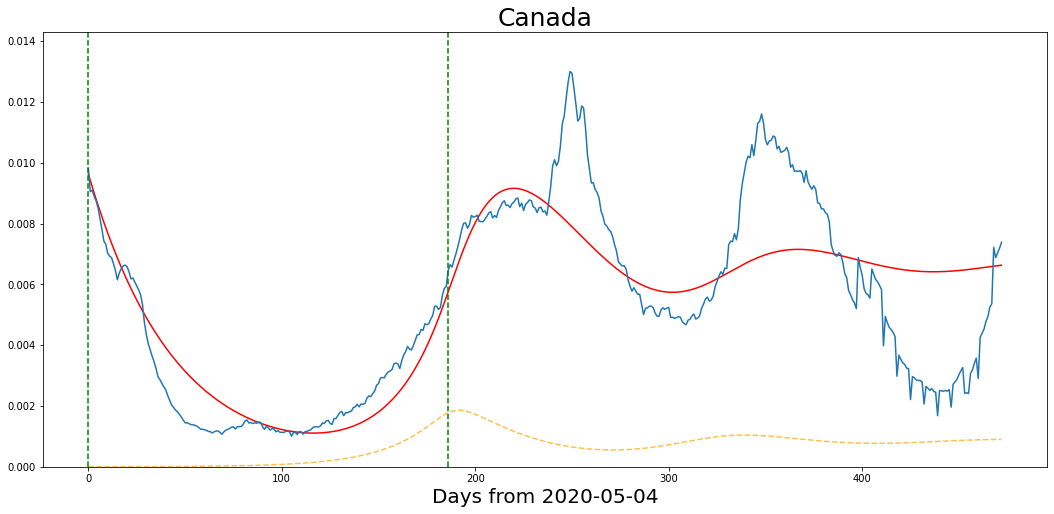

In [13]:
measureDates = getCountryDates("Canada")
    
dates, I, R, D, V = owid.LoadCountryNormal("Canada")

startDate = getIndex(dates, measureDates[1])

dates = dates[startDate:]
I = I[startDate:]

consts = [len(I), I[0], max(I), 0]

canadaParamsLate = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(canadaParamsLate, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])


ax.set_title("Canada", fontsize=25)
ax.set_xlabel("Days from " + dates[0], fontsize=20)

measureDates = getCountryDates("Canada")

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')
            
print("Canada", canadaParamsLate, dates[0], dates[-1])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt


#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta10, beta11, beta12..., , beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, [measure indexes] ]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(7 + len(consts[3]))
        
    params[0] = .001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    
    for i in range(len(consts[3])):
        params[6+i] = 13 + 125*random.random() #beta2, scaler on feedback, changes for each parameter
    params[-1] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    measures = consts[3]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    b0 = params[5]
    b1 = params[6:len(params)]
    b2 = params[-1]

    #print(params)
    
    currMeasure = 0
    currB1 = params[6+currMeasure] #th+e starting beta

    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        
        while(t >= measures[currMeasure]): #we just passed a measure date
            currMeasure = currMeasure + 1
            currB1 = measures[currMeasure]
        
        diffA = (b0/ (1 + (currB1*I[t])**(b2) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax


#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):

    x = simFunc(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    consts[3].append(consts[0]) #add 1 measure to the end which is the last day + 1
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

2020-02-26 ['2020-03-08' '2020-05-04' '2020-11-04']
0 New best error:  2.613098823757037e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


1 New best error:  1.4429105419302441e-05
[ 4.65618931e-04  2.54260100e-03  1.02578579e+00  1.37391531e-01
  1.12711375e-02  3.14374983e+00  1.82922044e+02  6.98653265e+01
  1.11371526e+01 -4.14535741e+01  3.65850131e+00]


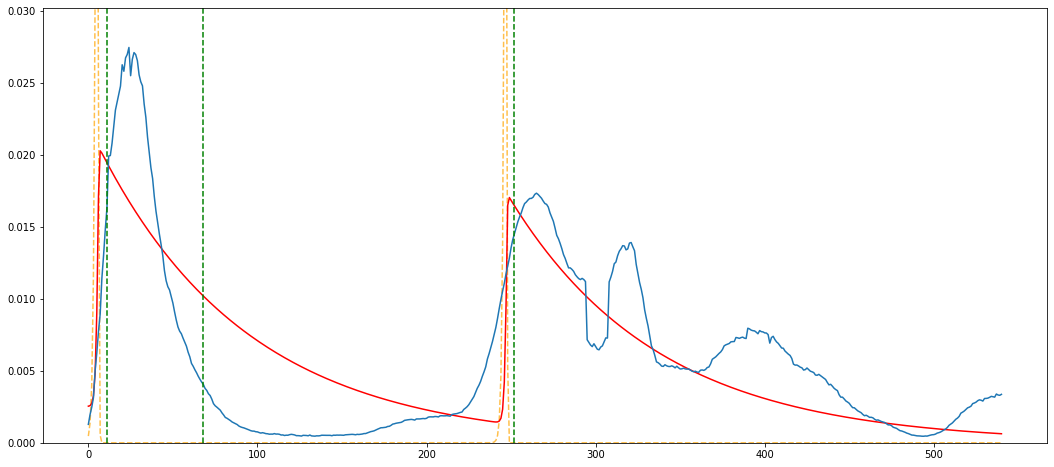

In [15]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")

measureDates = getCountryDates("Italy")
print(dates[0], measureDates)
    
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))

consts = [len(I), I[0], max(I), measureIndexes]

italyParams = getParams(I, consts, randomIterCount=50, method = "Nelder-Mead")

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(italyParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
        plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')


2020-04-01 ['2020-03-20' '2020-05-10' '2020-06-15' '2020-10-12' '2020-10-31'
 '2020-11-28' '2021-04-12']


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  1.6482179697473253e-05
7 New best error:  1.6426897872428573e-05
10 New best error:  1.535724098773177e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in double_scalars


[ 3.52401336e-03  5.48367471e-06  1.51219486e-01  1.23937056e+00
  4.25057667e-02  1.73925595e-01  1.53745772e+03 -8.69908046e+02
 -4.33484181e+02  4.96753357e+02 -4.00229853e+02 -7.41344807e+02
 -1.39461099e+02 -1.71887379e+03  7.87324979e+01]


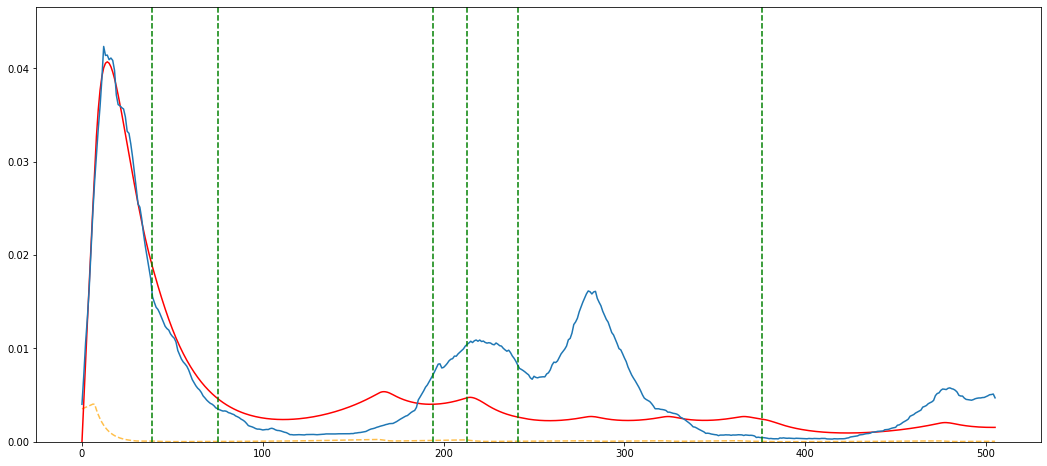

In [11]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")

measureDates = getCountryDates("United Kingdom")
print(dates[0], measureDates)
    
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))

consts = [len(I), I[0], max(I), measureIndexes]

ukParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(ukParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
        plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt


#parameters are [A(0), I(0), gamma0, gamma1, nu, beta00, beta1, be0ta02..., beta1, beta2]
#consts are [dayNum, I[0], maxI, [measure indexes] ]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(7 + len(consts[3]))
        
    params[0] = .001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    for i in range(len(consts[3])):
        params[5+i] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    
    params[-2] = 13 + 125*random.random() #beta2, scaler on feedback, changes for each parameter
    params[-1] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    measures = consts[3]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    b1 = params[-2]
    b2 = params[-1]

    #print(params)
    
    currMeasure = 0
    currB0 = params[5+currMeasure] #th+e starting beta

    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        
        while(t >= measures[currMeasure]): #we just passed a measure date
            currMeasure = currMeasure + 1
            currB0 = measures[currMeasure]
        
        diffA = (currB0/ (1 + (b1*I[t])**(b2) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax


#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):

    x = simFunc(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    consts[3].append(consts[0]) #add 1 measure to the end which is the last day + 1
    
    
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

2020-02-26 ['2020-03-08' '2020-05-04' '2020-11-04']


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  0.8482918516034071
4 New best error:  2.7859632654612243e-05
7 New best error:  2.2834021950234553e-05
8 New best error:  2.0621154884393598e-05
9 New best error:  1.899396470043748e-05
14 New best error:  1.825018282489173e-05
28 New best error:  1.7817474785943077e-05
42 New best error:  1.770835508611132e-05
[ 9.44996285e-05  3.29456223e-04  3.96816691e-02  3.77335450e-01
  9.64835632e-02  2.32620293e+00 -1.05369426e+01  2.56424626e-03
  5.48344939e-01  8.46803112e+02  6.50136792e+00]


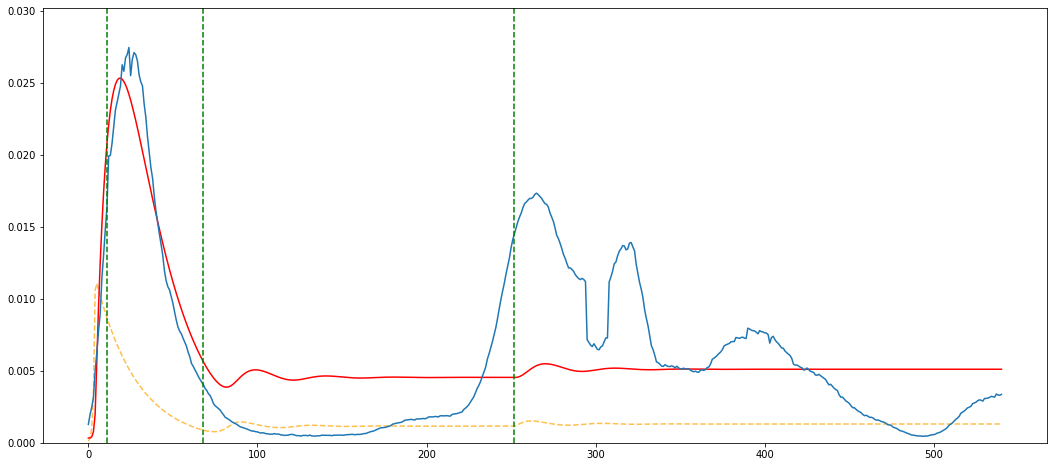

In [38]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")

measureDates = getCountryDates("Italy")
print(dates[0], measureDates)
    
measureIndexes = []
for measure in measureDates:
    measureIndexes.append(getIndex(dates, measure))

consts = [len(I), I[0], max(I), measureIndexes]

italyParams = getParams(I, consts, randomIterCount=50, method = "Nelder-Mead")

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(italyParams)

for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')